# Allowing Import from Parent Directory

In [12]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

#Importing Packages

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tools.loaddata as loaddata
import tools.dataassimilation as da
import tools.visualisation as visual

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Loading and Reshaping Data

In [ ]:
path_train = "../data/train/"
path_test = "../data/test/"
path_back = "../data/background/"
path_obs = "../data/satellite/"

In [4]:
train_full, test, model_data, satellite_data = loaddata.load_all_data(path_train, path_test, path_back, path_obs)

In [5]:
train = train_full[0:1200]

In [6]:
print(f"Train data before reshaping: {np.shape(train)}")
print(f"Test data before reshaping: {np.shape(test)}")
print(f"background data before reshaping: {np.shape(model_data)}")
print(f"observational data before reshaping: {np.shape(satellite_data)}")

Train data before reshaping: (1200, 871, 913)
Test data before reshaping: (300, 871, 913)
background data before reshaping: (5, 871, 913)
observational data before reshaping: (5, 871, 913)


In [7]:
train_1D, test_1D, model_data_1D, satellite_data_1D = loaddata.reshape_all_datasets(train, test, model_data, satellite_data)


In [8]:
print(f"Train data after reshaping: {train_1D.shape}")
print(f"Test data after reshaping: {test_1D.shape}")
print(f"Model data after reshaping: {model_data_1D.shape}")
print(f"Observational data after reshaping: {satellite_data_1D.shape}")

Train data after reshaping: (1200, 795223)
Test data after reshaping: (300, 795223)
Model data after reshaping: (5, 795223)
Observational data after reshaping: (5, 795223)


#Non-linear Autoencoder

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(128, input_shape=[795223], activation="elu"),
                                   keras.layers.Dense(64)])
decoder = keras.models.Sequential([keras.layers.Dense(128, input_shape=[64], activation="elu"),
                                   keras.layers.Dense(795223, activation='sigmoid')])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(),
                    metrics=['mse'])
print('Encoder:')                    
encoder.summary()
print('\nDencoder:')
decoder.summary()
print('\nAutoencoder:')
autoencoder.summary()

Encoder:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               101788672 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
Total params: 101,796,928
Trainable params: 101,796,928
Non-trainable params: 0
_________________________________________________________________

Dencoder:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 795223)            102583767 
                                                                 


In [10]:
# Callback to prevent overfitting

earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
start = time.time()
history = autoencoder.fit(train_1D, 
                          train_1D, 
                          epochs=50, 
                          batch_size=32, 
                          verbose=2, 
                          validation_data = (test_1D, test_1D), 
                          shuffle = True, callbacks = [earlystopping])
time_ae = time.time() - start
print('Execution time: ', time_ae)

In [13]:
# The validation loss began to increase when the number of epochs
# was at 38. This means that the model begins to overfit the data after 38 epochs.
# The optimum combination of epoch size and batch size we found is 38 and 32 respectively, with 64 hidden layers. 

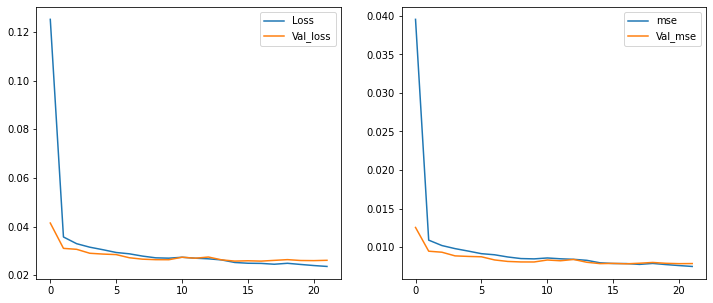

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].legend(['Loss', 'Val_loss'])
axes[1].plot(history.history['mse'])
axes[1].plot(history.history['val_mse'])
axes[1].legend(['mse', 'Val_mse'])

In [15]:
test_recovered = autoencoder.predict(test_1D)
mse_test = da.mse(test_1D, test_recovered)
print('mse: ', mse_test)

mse:  0.007834356550550689


#Data Assimilation - Kalman Filter (BLUE)

By adjusting the error covariance matrices R and B, we found that the following forms of matrices give us the lowest mse result after data assimilation.

In [16]:
model_data_compr = encoder.predict(model_data_1D)
satellite_data_compr = encoder.predict(satellite_data_1D)

latent_space = satellite_data_compr.shape[1]
nNodes = latent_space  # latent_space is the size of the compressed variables or number of principal components used
I = np.identity(nNodes)
R = np.cov(satellite_data_compr.T)
H = I 
B = I * 0.000000001

In [17]:
## Performing data assimilation
updated_data_array = da.assimilate(B, H, R, model_data_compr, satellite_data_compr)

## Printing MSE in latent space
mse_before_DA = da.mse(satellite_data_compr, model_data_compr)
mse_after_DA = da.mse(satellite_data_compr, updated_data_array)
print('MSE before assimilation in latent space: ', mse_before_DA )
print('MSE after assimilation in latent space: ', mse_after_DA)

## Printing MSE in Physical space space
updated_data_recon = decoder.predict(updated_data_array)
mse_before_DA_physical = da.mse(satellite_data_1D, model_data_1D)
mse_after_DA_physical = da.mse(satellite_data_1D, updated_data_recon)

print('MSE before assimilation in physical space: ', mse_before_DA_physical)
print('MSE after assimilation in physical space: ', mse_after_DA_physical)

MSE before assimilation in latent space:  4188.5737
MSE after assimilation in latent space:  715.8404601641759
MSE before assimilation in physical space:  0.1191695914227833
MSE after assimilation in physical space:  0.08701994260920441


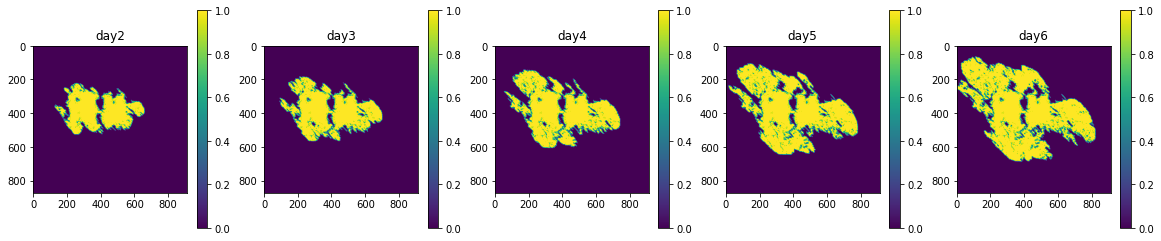

In [18]:
# Plot model data
visual.plot_data(model_data)

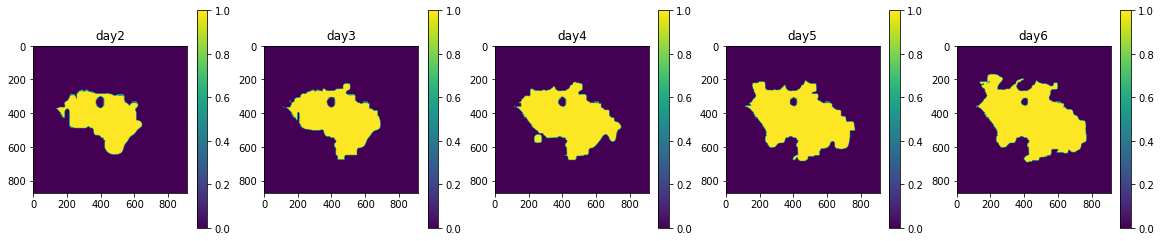

In [19]:
# Plot satellite data 
visual.plot_data(satellite_data)

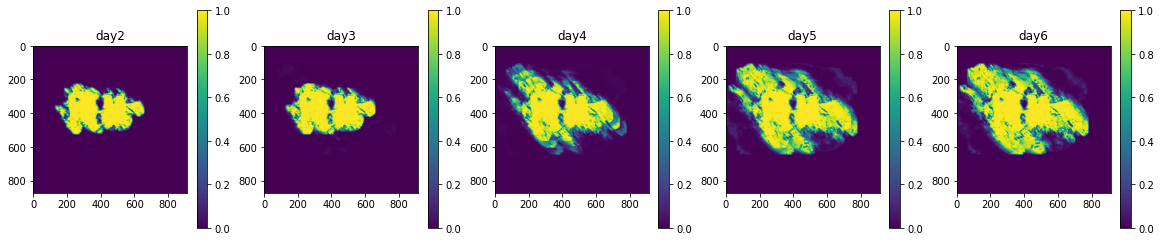

In [20]:
# Plot reconstructed model
updated_data_recon = np.reshape(updated_data_recon, (5, 871, 913))
visual.plot_data(updated_data_recon)